# Standalone Notebook for SynFS - Vanila MNIST
- horizontal view (3 & 8), wo artificial bias


In [1]:
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
import math
from functools import reduce
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#mnist
from torchvision import datasets, transforms

/home/chkim/anaconda3/envs/synergy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
config = {
      "views_dims": [392, 392],
      "hidden_dims": [400, 200, 300], 
      "s_lam": 0.4,
      "n_lam": 4,
      "alpha": 0.09,
      "learning_rate": 0.001, 
      "s_learning_rate":0.002,
      "batch_size": 250, 
      "weight_decay": 1e-4,
      "epochs": 100}

In [4]:
top_k = 28

In [5]:
train_set_raw = datasets.MNIST(
    root = '/mnt/storage/personal/chkim/MNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
)
test_set_raw = datasets.MNIST(
    root = '/mnt/storage/personal/chkim/MNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
)


In [6]:
def filter_data(train_set_raw, test_set_raw, label1, label2):
    """
    label1 :3
    lebel2 : 8
    """
    train_set = list(filter(lambda i: i[1] == int(label1) or i[1]== int(label2) , train_set_raw))  # train_set_raw (image, number_label)
    test_set = list(filter(lambda i: i[1] == int(label1) or i[1]==int(label2) , test_set_raw))
    return train_set, test_set

In [7]:
train_set, test_set = filter_data(train_set_raw, test_set_raw, 3,8)

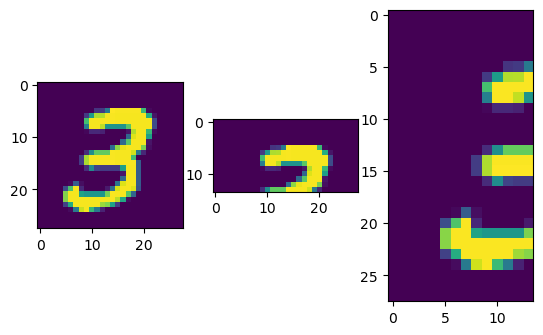

In [8]:
fig, axes = plt.subplots(1,3)
axes[0].imshow(train_set[0][0].reshape(28,28))
axes[1].imshow(train_set[0][0][:,:14,:].reshape(14,28))  # horizontal view 
axes[2].imshow(train_set[0][0][:,:,:14].reshape(28,14))  


In [9]:
def mnist_2_views_maker(data_set, label1, label2):
    """
    make mnist to two view dataset (vertically slice the image)
    return type ([view1,view2],label), view1 = (n, features)
    label1 :3 
    label2 :8
    """
    view1 = []
    view2 = []
    labels = []
    for i in range(len(data_set)): 
        if data_set[i][1]==int(label1):
            view1.append(data_set[i][0][:,:14,:].flatten())
            view2.append(data_set[i][0][:,14:,:].flatten())
            labels.append(0)

        elif data_set[i][1]==int(label2):
            view1.append(data_set[i][0][:,:14,:].flatten())
            view2.append(data_set[i][0][:,14:,:].flatten())
            labels.append(1)
        
        else :
            pass
    data = ([np.stack(view1, axis=0), np.stack(view2, axis=0)],np.array(labels))
    return data 


In [10]:
train_data = mnist_2_views_maker(train_set, 3, 8)
test_data = mnist_2_views_maker(test_set, 3, 8)

In [11]:
np.unique(train_data[1], return_counts=True)

(array([0, 1]), array([6131, 5851]))

1315


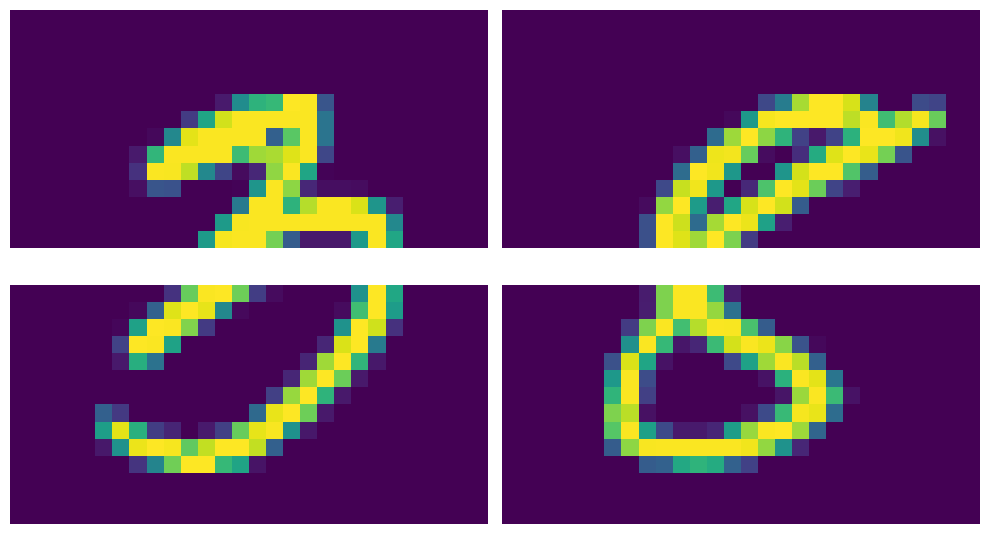

In [12]:
X_set = test_data[0]
number = np.random.randint(len(X_set[0]))
print(number)
for n in range(number, number+1):
    fig, axes = plt.subplots(2,2, figsize=(10,6))
    for idx, i in enumerate(range(n,n+2)):
        axes[0,idx].imshow(X_set[0][i].reshape(14,28))
        axes[1,idx].imshow(X_set[1][i].reshape(14,28))
        axes[0,idx].axis('off')
        axes[1,idx].axis('off')

plt.tight_layout()
plt.show()

In [13]:
train_set, test_set = filter_data(train_set_raw, test_set_raw, 3,8)
train_data = mnist_2_views_maker(train_set, 3, 8)
test_data = mnist_2_views_maker(test_set, 3, 8)


In [14]:
# train, val, test split
tr_X_set, tr_y = train_data[0], train_data[1]
te_X_set, te_y = test_data[0], test_data[1]
n = len(tr_X_set[1])
train_indices, val_indices = train_test_split(np.arange(n), test_size=0.2, random_state=0)
va_X_set, va_y = [X[val_indices] for X in tr_X_set], tr_y[val_indices]
tr_X_set, tr_y = [X[train_indices] for X in tr_X_set], tr_y[train_indices]

In [15]:
# scaling
scaled_tr_X_set, scalers = [], []
for i, view_data in enumerate(tr_X_set):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(view_data)
    scaled_tr_X_set.append(scaled_data)
    scalers.append(scaler)
scaled_va_X_set = [scalers[i].transform(va_X_set[i]) for i in range(len(va_X_set))]
scaled_te_X_set = [scalers[i].transform(te_X_set[i]) for i in range(len(te_X_set))]

tr_X_set, va_X_set, te_X_set = scaled_tr_X_set.copy(), scaled_va_X_set.copy(), scaled_te_X_set.copy()
        

In [16]:

class SimpleDataset(Dataset) :
    def __init__(self, data_set, y, device) :
        self.data_set = [torch.tensor(data, dtype=torch.float32).to(device) for data in data_set]
        self.y = torch.tensor(y).squeeze().long().to(device)
        self.device = device
        
    def __len__(self) :
        return len(self.data_set[0])
    
    def __getitem__(self, i) :
        xs = [data[i] for data in self.data_set]
        y = self.y[i]
        return (xs, y)

In [17]:
train_data = SimpleDataset(tr_X_set, tr_y, device=device)
trainloader = DataLoader(train_data, batch_size=config['batch_size'], drop_last=True)

# MODEL 

## Modules

In [18]:
class Selector(nn.Module):
    """Stochastic gate to discover selected features 
    
    Args:
        input_dim : dimension of input features
        sigma : constant for gaussian distribution
        device : device for the tensors to be created 
    """
    def __init__(self, input_dim, sigma=0.5, mean=0.5) -> None:
        super(Selector, self).__init__()
        self.mean = mean # 0.5
        self.mu = 0.01*torch.randn(input_dim,)
        self.mu = torch.nn.Parameter(self.mu, requires_grad=True)
        self.sigma = sigma
    
    def forward(self, prev_v, X_mean) -> None: 

        self.noise = torch.randn(prev_v.size()).to(self.mu.device)
        z = self.mu + self.sigma*self.noise.normal_()*self.training # noise normal_ ~N(0,1)
        self.z = z  # save z for the same noise
        stochastic_gate = self.hard_sigmoid(self.z)
        new_v = prev_v*stochastic_gate + X_mean*(1-stochastic_gate)
        return new_v
    
    def hard_sigmoid(self, v):
        return torch.clamp(v + self.mean, 0.0, 1.0)
    
    def regularizer(self, v):
        #guassian CDF
        return 0.5*(1 + torch.erf(v/math.sqrt(2)))
    
    def get_gates(self, mode='prob') :
        if mode == 'raw':
            return self.mu.detach().cpu().numpy()
        elif mode == 'prob':
            return np.minimum(1.0, np.maximum(0.0, self.mu.detach().cpu().numpy()+self.mean))
        

In [19]:
class MLP(nn.Module):
    def __init__(self, input_dim , hidden_dims, output_dim=2, batch_norm=True, dropout=True, activation='relu'):
        super(MLP, self).__init__()
        modules = self.build_layers(input_dim, hidden_dims, output_dim, batch_norm, dropout, activation)
        self.layers = nn.Sequential(*modules)
        
    def base_layer(self, in_features, out_features , batch_norm, dropout, activation):
        modules = [nn.Linear(in_features, out_features, bias=True)]
        if batch_norm : 
            modules.append(nn.BatchNorm1d(out_features))
        if dropout : 
            modules.append(nn.Dropout(0.5, True))
        if activation :
            modules.append(nn.ReLU(True))
        layer = nn.Sequential(*modules)
        return layer
    
    def build_layers(self, input_dim, hidden_dims, output_dim, batch_norm, dropout, activation) :
        dims = [input_dim]
        dims.extend(hidden_dims)
        dims.append(output_dim)
        nr_hiddens = len(hidden_dims)
        modules = []
        for i in range(nr_hiddens) :
            layer = self.base_layer(dims[i], dims[i+1], batch_norm, dropout, activation)
            modules.append(layer)
        layer = nn.Linear(dims[-2], dims[-1], bias=True)
        modules.append(layer)
        return modules
        
    def reset_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                module.reset_parameters()
                
    def forward(self, input):
        out = self.layers(input)
        return out 

In [20]:
class Model(nn.Module):
    def __init__(self, config):
        super(Model, self).__init__()
        self.s_selectors = nn.ModuleList()
        self.views_dims = config['views_dims']
        num_views = len(self.views_dims)
        for i in range(num_views):
            v_dim = self.views_dims[i]
            s_selector = Selector(v_dim)
            self.s_selectors.append(s_selector)
            setattr(self, f's_selector_{i}', s_selector)

        self.shared_predictor = MLP(sum(config['views_dims']), config['hidden_dims'],
                                )

In [21]:
def _standard_truncnorm_sample(lower_bound, upper_bound, sample_shape=torch.Size()):
    r"""
    Weight initialization usggested in STG
    """
    x = torch.randn(sample_shape)
    done = torch.zeros(sample_shape).byte()
    while not done.all():
        proposed_x = lower_bound + torch.rand(sample_shape) * (upper_bound - lower_bound)
        if (upper_bound * lower_bound).lt(0.0):  # of opposite sign
            log_prob_accept = -0.5 * proposed_x**2
        elif upper_bound < 0.0:  # both negative
            log_prob_accept = 0.5 * (upper_bound**2 - proposed_x**2)
        else:  # both positive
            assert(lower_bound.gt(0.0))
            log_prob_accept = 0.5 * (lower_bound**2 - proposed_x**2)
        prob_accept = torch.exp(log_prob_accept).clamp_(0.0, 1.0) #inplace
        accept = torch.bernoulli(prob_accept).byte() & ~done # return the prob_accept shape matrix where done is 0 
        if accept.any():
            accept = accept.bool()
            x[accept] = proposed_x[accept]
            accept = accept.byte()
            done |= accept # |=, in-place bitwise OR operator to done 
    return x

## SynFS

In [22]:
class SynFS(object):
    def __init__(self, config):
        """
        construct 
        s_model : a set of synergistic selector + predictor
        n_model : a set of non-synergistic selecotr + predictor
        inf_model : predictor
        """
        
        self.config = config
        self.batch_size = self.config['batch_size']
        self.device = self.get_device()
        self.loss = nn.CrossEntropyLoss(reduction='none')
        self.cos_loss = nn.CosineSimilarity(dim=0)

        self.s_model = Model(config)
        self.s_model.apply(self.init_weights)
        self.s_model.to(self.device)

        self.n_model = Model(config)
        self.n_model.apply(self.init_weights)
        self.n_model.to(self.device)
        
        self.inf_model = MLP(sum(config['views_dims']), config['hidden_dims'])
        self.inf_model.apply(self.init_weights)
        self.inf_model.to(self.device)
        
        self.sp_params = list(self.s_model.shared_predictor.parameters()) 
        self.np_params = list(self.n_model.shared_predictor.parameters()) 

        self.s_params = [p for selector in self.s_model.s_selectors for p in selector.parameters()] 
        self.n_params = [p for selector in self.n_model.s_selectors for p in selector.parameters()] 
        
        self.p_opt = torch.optim.Adam(self.sp_params+self.np_params, 
                                      lr=config['learning_rate'], 
                                      weight_decay=config['weight_decay']) # 
        self.synergy_opt = torch.optim.Adam(self.s_params, lr=config['s_learning_rate'])# list of optimizers
        self.nsynergy_opt = torch.optim.Adam(self.n_params, lr=config['s_learning_rate'])
        self.inf_opt = torch.optim.Adam(self.s_params + self.n_params + list(self.inf_model.parameters()),
                                            lr=config['learning_rate'], 
                                            weight_decay=config['weight_decay'])
    def get_device(self):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        return device
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            stddev = torch.tensor(0.1)
            shape = m.weight.shape
            m.weight = nn.Parameter(_standard_truncnorm_sample(lower_bound = -2*stddev, upper_bound = 2 * stddev, sample_shape = shape))
            torch.nn.init.zeros_(m.bias)
    
    def get_reg(self, selector):
        reg = selector.regularizer
        #reg = reg((selector.mu + selector.mean) / selector.sigma) #cdf
        reg = torch.mean(reg(selector.mu / selector.sigma))
        return reg
    
    def get_gates(self, model):
        S = [selector.hard_sigmoid(selector.mu.detach()) for selector in model.s_selectors]
        return S

    def mask_generator(self, batch_size=None):
        """
        Generate mask to use shared predictor with V marginal selectors
        """
        #generating mask for latent space
        # return a list of masks for each view 
        if batch_size is None:
            batch_size = self.config['batch_size']
        masks = []
        view_sum = sum(self.config['views_dims'])
        cumsum = np.cumsum(self.config['views_dims'])
        blank_mask = torch.zeros(batch_size, view_sum, device=self.device)
        for v in range(len(self.config['views_dims'])):
            v_mask = blank_mask.clone()
            if v == 0 :
                v_mask[:, :cumsum[v]] = 1
            else:
                v_mask[:, cumsum[v-1]:cumsum[v]] = 1
            masks.append(v_mask)
        return masks
    
    def simple_forward(self, model, S, views, X_mean_set):
        """
        simple forward to get P(Y|X_g_s) or P(Y|X_g_n)
        """
        masks = self.mask_generator(batch_size=views[0].shape[0])
        s_z = [S[i]*views[i]+(1-S[i])*X_mean_set[i] for i in range(len(views))]
        logits = []
        for v in range(len(self.config['views_dims'])):
            logit = model.shared_predictor(torch.cat(s_z, dim=1)*masks[v])
            logits.append(logit)
        bar_logit = model.shared_predictor(torch.cat(s_z, dim=1))
        logits.append(bar_logit)
        return logits 

    def train_step(self, data, X_mean_set):
        
        """"
        Train Predictor -> synergistic selector -> non-syergistic selector
        only corresponding weights specified for the loss are updated 
        
        """
        self.s_model.train()
        self.s_model.train()
        self.inf_model.train()
        
        views, y = data[:-1][0], data[-1]
        masks = self.mask_generator()
        
        # new v 
        v_s = [selector(views[i], X_mean_set[i]) for i, selector in enumerate(self.s_model.s_selectors)] 
        v_n = [selector(views[i], X_mean_set[i]) for i, selector in enumerate(self.n_model.s_selectors)]
        z_s = [selector.z for selector in self.s_model.s_selectors]
        z_n = [selector.z for selector in self.n_model.s_selectors]
        
        ###############################
        ###        Predictor       ###
        ###############################
        # with the same noise as with selectors  
        #  non-synergic
        
        n_logits, s_logits = [], []
        for v in range(len(self.config['views_dims'])):
            logit = self.n_model.shared_predictor(torch.cat(v_n, dim=1)*masks[v])
            n_logits.append(logit)
        n_v_bar_logits = self.n_model.shared_predictor(torch.cat(v_n, dim=1))
        n_logits.append(n_v_bar_logits)
        #  synergic
        for v in range(len(self.config['views_dims'])):
            logit = self.s_model.shared_predictor(torch.cat(v_s, dim=1)*masks[v])
            s_logits.append(logit)
        s_v_bar_logits = self.s_model.shared_predictor(torch.cat(v_s, dim=1))
        s_logits.append(s_v_bar_logits)
        
        n_losses = [self.loss(logit, y) for logit in n_logits]
        s_losses = [self.loss(logit, y) for logit in s_logits]
        p_loss = torch.mean(torch.sum(torch.stack(n_losses+s_losses, dim=1), dim=1))

        self.p_opt.zero_grad() 
        p_loss.backward(retain_graph=True) # s_selector, n_selector, predictors 
        self.p_opt.step()  # update predictors
        
        #####################################
        ###   Synergic Selector and Inf   ###
        #####################################
        
        n_logits, s_logits = [], []
        # informative gate (max(synergic gate , non-synergic gate))
        all_gates = [self.s_model.s_selectors[0].hard_sigmoid(torch.max(s, n)) for s, n in zip(z_s, z_n)]  # with noise
        all_v = [views[i]*gate + X_mean_set[i]*(1-gate) for i, gate in enumerate(all_gates)]
        gate_s, gate_n = [self.s_model.s_selectors[0].hard_sigmoid(s) for s in z_s], [self.s_model.s_selectors[0].hard_sigmoid(n) for n in z_n] 
        s_regs =[self.get_reg(selector) for selector in self.s_model.s_selectors]
        
        all_bar_logits = self.inf_model(torch.cat(all_v, dim=1))
        all_bar_loss = self.loss(all_bar_logits, y)

        for v in range(len(self.config['views_dims'])):
            logit = self.s_model.shared_predictor(torch.cat(v_s, dim=1)*masks[v])
            s_logits.append(logit)
        s_v_bar_logits = self.s_model.shared_predictor(torch.cat(v_s, dim=1))

        s_losses = [self.loss(logit, y) for logit in s_logits]
        s_v_bar_loss = self.loss(s_v_bar_logits, y)
        inf_loss = torch.mean(all_bar_loss) 
        
        synergy_loss = torch.mean(s_v_bar_loss - torch.sum(torch.stack(s_losses, dim=1), dim=1) \
                                + self.config['s_lam']*torch.mean(torch.stack(s_regs)) \
                                )

        self.inf_opt.zero_grad()
        self.synergy_opt.zero_grad()
        inf_loss.backward(retain_graph=True) #s selecotr, n selector, ai predictor 
        synergy_loss.backward() # s selector, predictors 

        self.inf_opt.step()  
        self.synergy_opt.step()
        
        ##########################
        ###   Non-syneristic   ###
        ##########################

        sim = torch.nn.functional.cosine_similarity(torch.cat(gate_s, dim=1), torch.cat(gate_n, dim=1), dim=1) #(batch, alldim)
        ns_regs =[self.get_reg(selector) for selector in self.n_model.s_selectors]
        
        for v in range(len(self.config['views_dims'])):
            logit = self.n_model.shared_predictor(torch.cat(v_n, dim=1)*masks[v])
            n_logits.append(logit)
        n_v_bar_logits = self.n_model.shared_predictor(torch.cat(v_n, dim=1))
        
        n_losses = [self.loss(logit, y) for logit in n_logits]
        n_v_bar_loss = self.loss(n_v_bar_logits, y)

        nsynergy_loss = torch.mean(-n_v_bar_loss + torch.sum(torch.stack(n_losses, dim=1), dim=1) 
                                   + self.config['n_lam']*torch.mean(torch.stack(ns_regs)) # same mu for all batch
                                   + self.config['alpha']*sim 
                                   )
        
        self.nsynergy_opt.zero_grad()
        nsynergy_loss.backward() # n selector, predcitor 
        self.nsynergy_opt.step()
        
        return synergy_loss, nsynergy_loss, inf_loss

    def predict(self, views, te_X_set):
        self.s_model.eval()
        self.n_model.eval()
        self.inf_model.eval()
        
        X_mean_set = [torch.mean(torch.Tensor(X).to(self.device), dim=0) for X in te_X_set] 

        with torch.no_grad():
            S = self.get_gates(self.s_model)
            NS = self.get_gates(self.s_model)
            all_mu = [torch.max(s, ns) for s, ns in zip(S, NS)]
            all_z = [all_mu[i]*views[i]+(1-all_mu[i])*X_mean_set[i] for i in range(len(views))]
            all_bar_logits = self.inf_model(torch.cat(all_z, dim=1))
        return all_bar_logits


In [23]:
synfs = SynFS(config)
X_mean_set = [torch.mean(torch.Tensor(X).to(device), dim=0) for X in tr_X_set]

In [24]:

def highest_n_gates(gates, n=6): 
    #return gate with 6 hightest gate 
    n = 6
    ai_gates_ = []
    for gate in gates:
        indices = np.argsort(gate)[-n:]
        gate = np.zeros_like(gate)
        gate[indices] = 1
        ai_gates_.append(gate)
        
    return ai_gates_

In [25]:
print("===Synergistic gate Training===")

for epoch in range(config['epochs']):
    syn_loss=0
    for batch in trainloader:
        synergy_loss, nsynergy_loss, inf_loss = synfs.train_step(batch, X_mean_set)
        syn_loss +=synergy_loss
    avg_syn_loss = syn_loss/len(trainloader)
    if epoch % 30 == 0:
        print(f'=====epoch {epoch} syn_loss {avg_syn_loss.item():.3f}=====')
        print('predicted synergistic features')
        print(np.where(np.concatenate([g.cpu().numpy() for g in synfs.get_gates(synfs.s_model)])>0.7)[0])
        print('predicted non-synergistic features')
        print(np.where(np.concatenate([g.cpu().numpy() for g in synfs.get_gates(synfs.n_model)])>0.7)[0])
        


===Synergistic gate Training===
=====epoch 0 syn_loss -0.608=====
predicted synergistic features
[]
predicted non-synergistic features
[]
=====epoch 30 syn_loss -0.592=====
predicted synergistic features
[190 218 242 272 299 301 328 509 536 537 565 593 650 651 652 653 654 655
 664 678 680 681 682 683 709 710]
predicted non-synergistic features
[264 290 291 292 293 317 319 514 516 517]
=====epoch 60 syn_loss -0.768=====
predicted synergistic features
[190 218 242 299 300 301 328 329 357 537 565 593 651 652 653 654 655 678
 682 709 710]
predicted non-synergistic features
[264 290 292 293 294 317 319 344 460 485 512 514 516 517]
=====epoch 90 syn_loss -0.804=====
predicted synergistic features
[181 190 213 214 218 299 300 301 357 537 651 652 654 678 709]
predicted non-synergistic features
[264 290 292 293 294 317 319 344 347 373 460 485 512 514 516 517 570]


In [26]:
# gate plot
def get_gates(model, threshold=None):
    # return list of view gates, concat of view gate 
    model_gate = synfs.get_gates(model)
    if threshold is None:
        gates = [gate.cpu().numpy() for gate in model_gate]
    else:
        gates = [np.where(gate.cpu().numpy()>threshold, 1, 0) for gate in model_gate]
    a, b = gates
    gate = np.concatenate([a,b])
    return gates, gate 


In [27]:
s_gates, s_gate = get_gates(synfs.s_model)
n_gates, n_gate = get_gates(synfs.n_model)

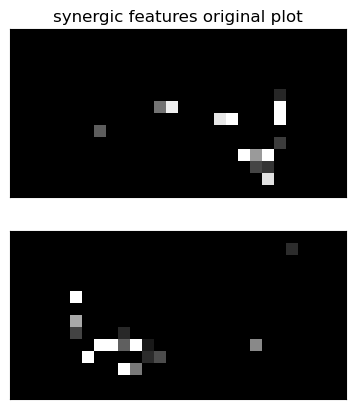

In [28]:
fig, axes = plt.subplots(2,1)
axes[0].set_title(f"synergic features original plot")
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)
axes[1].xaxis.set_visible(False)
axes[1].yaxis.set_visible(False)
axes[0].imshow(s_gates[0].reshape(14,28), cmap='gray');
axes[1].imshow(s_gates[1].reshape(14,28), cmap='gray');


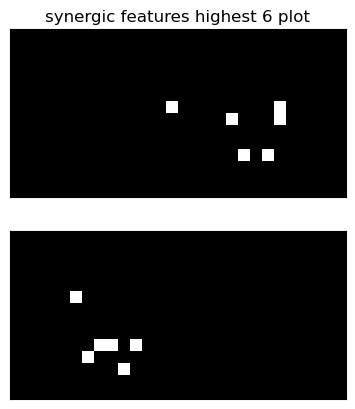

In [29]:
n = 6
s_gates_ = highest_n_gates(s_gates, n)
fig, axes = plt.subplots(2,1)
axes[0].set_title(f"synergic features highest {n} plot")
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)
axes[1].xaxis.set_visible(False)
axes[1].yaxis.set_visible(False)
axes[0].imshow(s_gates_[0].reshape(14,28), cmap='gray');
axes[1].imshow(s_gates_[1].reshape(14,28), cmap='gray');

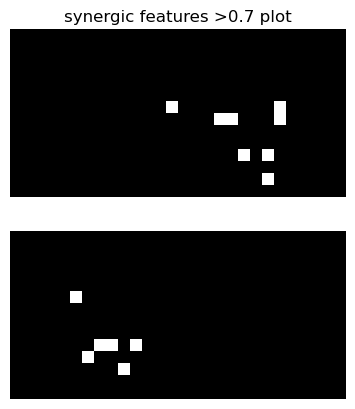

In [30]:
fig, axes = plt.subplots(2,1)
axes[0].set_title(f"synergic features >0.7 plot")
axes[0].axis('off')      
axes[1].axis('off')  
axes[0].imshow(np.where(s_gates[0]>0.7, 1, 0).reshape(14,28), cmap='gray');
axes[1].imshow(np.where(s_gates[1]>0.7, 1, 0).reshape(14,28), cmap='gray');

In [31]:
np.where(s_gates[0]>0.7)[0]

array([181, 190, 213, 214, 218, 299, 301, 357])

556


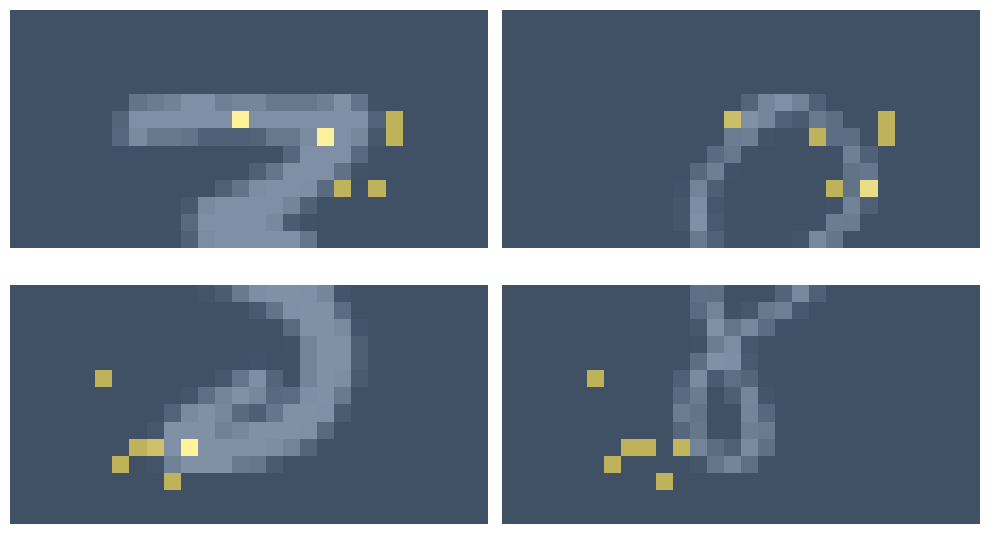

In [32]:
#number = 5052
number = 556 #1626
#number = np.random.randint(len(X_set[0]))
print(number)

fig, axes = plt.subplots(2,2, figsize=(10,6))
s_gates_ = highest_n_gates(s_gates, top_k/2)
for idx, i in enumerate(range(number, number+2)):
    axes[0,idx].imshow(X_set[0][i].reshape(14,28), cmap='gray', alpha=0.5)
    #axes[0,idx].imshow(np.where(s_gates[0]>0.7, 1, 0).reshape(14,28), cmap='cividis', alpha=0.5)
    axes[0,idx].imshow(s_gates_[0].reshape(14,28), cmap='cividis', alpha=0.5)
    axes[1,idx].imshow(X_set[1][i].reshape(14,28), cmap='gray', alpha=0.5)
    #axes[1,idx].imshow(np.where(s_gates[1]>0.7, 1, 0).reshape(14,28), cmap='cividis', alpha=0.5)
    axes[1,idx].imshow(s_gates_[1].reshape(14,28), cmap='cividis', alpha=0.5)
    axes[0,idx].axis('off')      
    axes[1,idx].axis('off')     
plt.tight_layout()
plt.show()

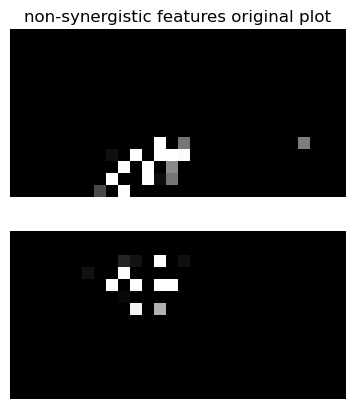

In [33]:
fig, axes = plt.subplots(2,1)
axes[0].set_title(f"non-synergistic features original plot")
axes[0].imshow(n_gates[0].reshape(14,28), cmap='gray');
axes[1].imshow(n_gates[1].reshape(14,28), cmap='gray');
axes[0].axis('off')
axes[1].axis('off');

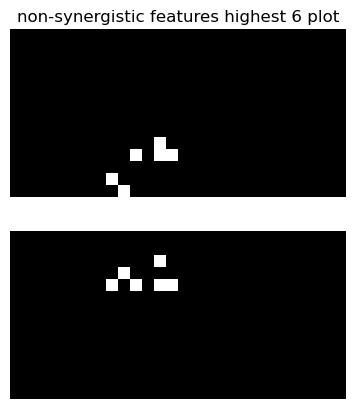

In [34]:
n = 6
n_gates_ = highest_n_gates(n_gates, n)
fig, axes = plt.subplots(2,1)
axes[0].set_title(f"non-synergistic features highest {n} plot")
axes[0].imshow(n_gates_[0].reshape(14,28), cmap='gray');
axes[1].imshow(n_gates_[1].reshape(14,28), cmap='gray');
axes[0].axis('off')
axes[1].axis('off');

556


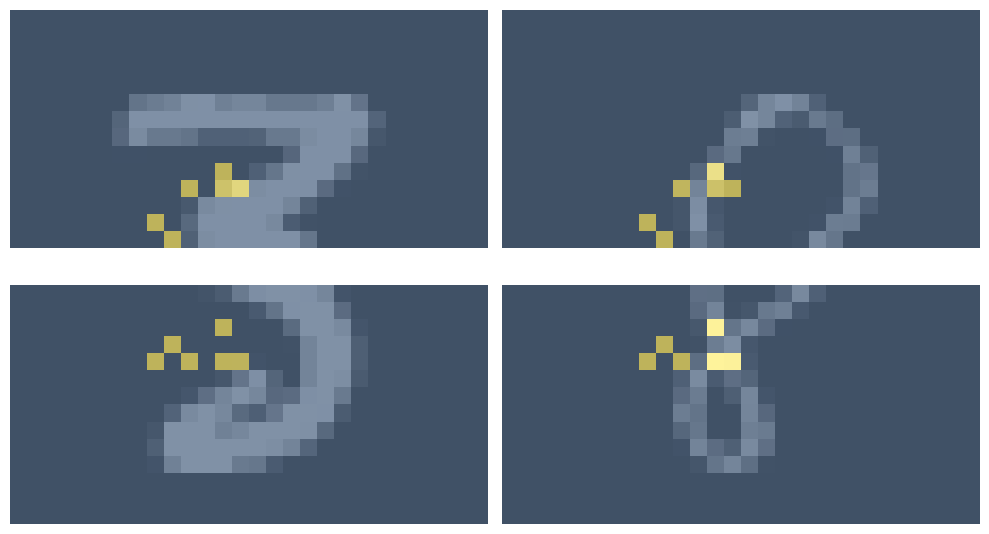

In [35]:
number = 556
#number = 5052
#number = np.random.randint(len(X_set[0]))
print(number)
n_gates_ = highest_n_gates(n_gates, top_k/2)
for n in range(number, number+1):
    fig, axes = plt.subplots(2,2, figsize=(10,6))
    for idx, i in enumerate(range(n, n+2)):
        axes[0,idx].imshow(X_set[0][i].reshape(14,28), cmap='gray', alpha=0.5)
        axes[0,idx].imshow(n_gates_[0].reshape(14,28), cmap='cividis', alpha=0.5)
        axes[1,idx].imshow(X_set[1][i].reshape(14,28), cmap='gray', alpha=0.5)
        axes[1,idx].imshow(n_gates_[1].reshape(14,28), cmap='cividis', alpha=0.5)
        axes[0,idx].axis('off')      
        axes[1,idx].axis('off')    

plt.tight_layout()
plt.show()

In [38]:
# Test
test_data = SimpleDataset(te_X_set, te_y, device='cuda')
test_loader = DataLoader(test_data, batch_size=len(te_y))

In [39]:
# all inf 
res = []
for x, y in test_loader:
    logits = synfs.predict(x, te_X_set)
    res.append(logits.detach().cpu().numpy())
logits = np.concatenate(res)
        
# Metric 
def np_softmax(target, all):
    softmax = np.exp(target) / np.sum(np.exp(all) ,axis=1)
    return softmax
    
threshold = np.sum(tr_y[tr_y==1])/ len(tr_y)
threshold = threshold
y_prob = np_softmax(logits[:,1], logits)
y_pred = np.where(y_prob > threshold, 1, 0)

auroc = roc_auc_score(te_y, logits[:,1])
auprc = average_precision_score(te_y, logits[:,1])
accuracy = accuracy_score(te_y, y_pred)
f1 = f1_score(te_y, y_pred)
print(f"auroc | {auroc.item():.3f}, auprc | {auprc.item():.3f}, accuracy | {accuracy.item():.3f}, f1 | {f1.item():.3f}")



auroc | 0.854, auprc | 0.864, accuracy | 0.725, f1 | 0.761
